In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [2]:
calls = pd.read_csv('./data/callsf0d4f5a.csv')
customers = pd.read_csv('data/customers2afd6ea.csv')
reasons = pd.read_csv('data/reason18315ff.csv')
sentiments = pd.read_csv('data/sentiment_statisticscc1e57a.csv')

In [3]:
# Merge the data
data = pd.merge(calls, customers, on='customer_id', how='left')
data = pd.merge(data, reasons, on='call_id', how='left')
data = pd.merge(data, sentiments, on='call_id', how='left')

In [4]:
data = data.drop(columns=['agent_id_y'])
data = data.rename(columns={'agent_id_x': 'agent_id'})

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  71810 non-null  int64  
 1   customer_id              71810 non-null  int64  
 2   agent_id                 71810 non-null  int64  
 3   call_start_datetime      71810 non-null  object 
 4   agent_assigned_datetime  71810 non-null  object 
 5   call_end_datetime        71810 non-null  object 
 6   call_transcript          71810 non-null  object 
 7   customer_name            71810 non-null  object 
 8   elite_level_code         46043 non-null  float64
 9   primary_call_reason      66653 non-null  object 
 10  agent_tone               71593 non-null  object 
 11  customer_tone            71810 non-null  object 
 12  average_sentiment        71701 non-null  float64
 13  silence_percent_average  71810 non-null  float64
dtypes: float64(3), int64(3

In [6]:
data['call_start_datetime'] = pd.to_datetime(data['call_start_datetime'])
data['agent_assigned_datetime'] = pd.to_datetime(data['agent_assigned_datetime'])
data['call_end_datetime'] = pd.to_datetime(data['call_end_datetime'])

data['call_duration'] = (data['call_end_datetime'] - data['call_start_datetime']).dt.total_seconds()

data['AHT'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()
data['AST'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds()

In [7]:
data['duration_to_start'] = data['agent_assigned_datetime'] - data['call_start_datetime'] 
data['duration_to_start'] = data['duration_to_start'].dt.total_seconds()

### Handling Missing Data
#### ~~elite_level_code~~, primary_call_reason, agent_tone, average_sentiment

In [8]:
# Check for missing values
print(data.isnull().sum())

call_id                        0
customer_id                    0
agent_id                       0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
customer_name                  0
elite_level_code           25767
primary_call_reason         5157
agent_tone                   217
customer_tone                  0
average_sentiment            109
silence_percent_average        0
call_duration                  0
AHT                            0
AST                            0
duration_to_start              0
dtype: int64


In [9]:
# Print the first five instances of the data where the elite_level_code is missing
data[data['elite_level_code'].isnull()].head()

,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,call_duration,AHT,AST,duration_to_start
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,calm,neutral,0.02,0.35,900.0,720.0,180.0,180.0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,neutral,polite,-0.13,0.32,1620.0,1140.0,480.0,480.0
6,324593040,6774865122,519057,2024-08-01 00:08:00,2024-08-01 00:21:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,James Lawrence,NaN,Checkout,neutral,frustrated,0.00,0.25,1560.0,780.0,780.0,780.0
9,4113684017,1528835057,158319,2024-08-01 00:20:00,2024-08-01 00:28:00,2024-08-01 00:37:00,\n\nAgent: Thank you for calling United Airlin...,Jonathan Parker,NaN,IRROPS,neutral,angry,-0.19,0.29,1020.0,540.0,480.0,480.0
11,7732610078,4029953261,488324,2024-08-01 00:23:00,2024-08-01 00:34:00,2024-08-01 01:32:00,\n\nAgent: Thank you for calling United Airlin...,Cassandra Flores,NaN,NaN,neutral,neutral,-0.06,0.58,4140.0,3480.0,660.0,660.0


In [10]:
data['elite_level_code'].value_counts()

elite_level_code
0.0    14387
1.0    14370
2.0     8028
3.0     5736
4.0     2125
5.0     1397
Name: count, dtype: int64

In [11]:
# Assuming that the missing values denote no membership, we can fill the missing values with 0.0
elite_code_mode = data['elite_level_code'].mode()[0]
data['elite_level_code'] = data['elite_level_code'].fillna(elite_code_mode)

In [12]:
data['primary_call_reason'].value_counts()

primary_call_reason
IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            149
Seating                      142
Digital   Support      

### Percentage difference between the average handling time for the most frequent and least frequent call reasons

In [13]:
# Analyze the relationship between volume and AHT/AST
call_reason_volume = data['primary_call_reason'].value_counts()
high_volume_reasons = call_reason_volume.index[:5]  # Top 5 most frequent reasons

high_volume_stats = data[data['primary_call_reason'].isin(high_volume_reasons)].groupby('primary_call_reason').agg(
    mean_AHT=('AHT', 'mean'),
    mean_AST=('AST', 'mean')
)

print(high_volume_stats)

                       mean_AHT    mean_AST
primary_call_reason                        
IRROPS               785.491307  360.174619
Mileage Plus         995.724440  361.224713
Post-Flight          928.410442  569.294391
Seating              475.728748  570.814720
Voluntary Change     639.564668  540.810417


In [14]:
# Most and least frequent call reasons
most_frequent_reason = call_reason_volume.idxmax()
least_frequent_reason = call_reason_volume.idxmin()

# Calculate mean AHT for these reasons
most_frequent_aht = data[data['primary_call_reason'] == most_frequent_reason]['AHT'].mean()
least_frequent_aht = data[data['primary_call_reason'] == least_frequent_reason]['AHT'].mean()

# Calculate percentage difference
percentage_difference_aht = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100
print(f"Percentage difference in AHT between most and least frequent call reasons: {percentage_difference_aht:.2f}%")


Percentage difference in AHT between most and least frequent call reasons: 336.38%


### Analysing Sentiment as a key factor

In [15]:
# Group by customer_tone, agent_tone, and primary_call_reason to calculate mean AHT and AST
sentiment_stats = data.groupby(['customer_tone', 'agent_tone', 'primary_call_reason']).agg(
    mean_AHT=('AHT', 'mean'),
    mean_AST=('AST', 'mean')
).reset_index()

# Display the top few rows for an overview
print(sentiment_stats.head())

  customer_tone agent_tone primary_call_reason  mean_AHT    mean_AST
0         angry      angry             Baggage     180.0  540.000000
1         angry      angry             Baggage      60.0  540.000000
2         angry      angry            Check-In     510.0  300.000000
3         angry      angry            Checkout     600.0  737.142857
4         angry      angry      Communications     375.0  210.000000


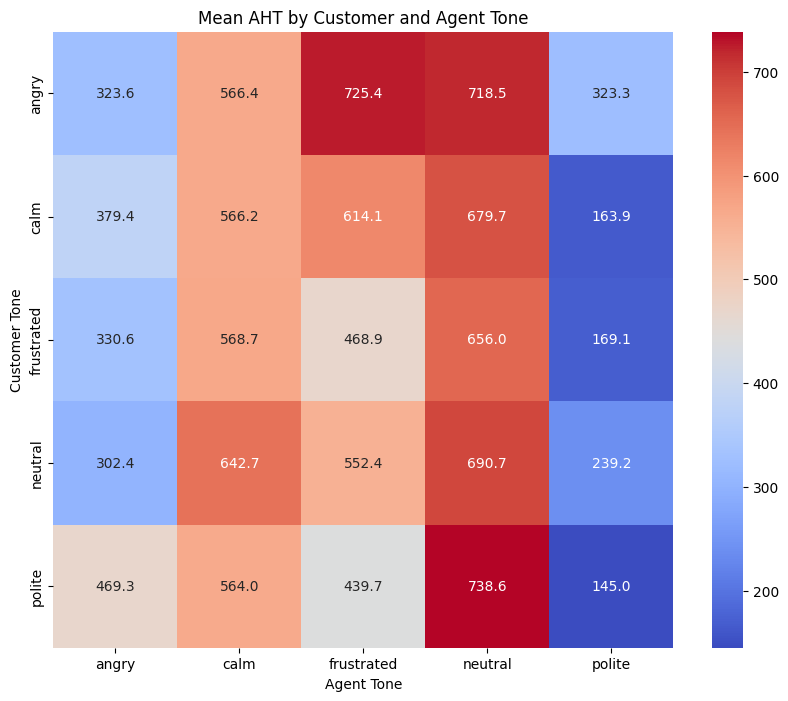

In [16]:
heatmap_data_aht = sentiment_stats.pivot_table(index='customer_tone', columns='agent_tone', values='mean_AHT')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_aht, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Mean AHT by Customer and Agent Tone')
plt.ylabel('Customer Tone')
plt.xlabel('Agent Tone')
plt.show()

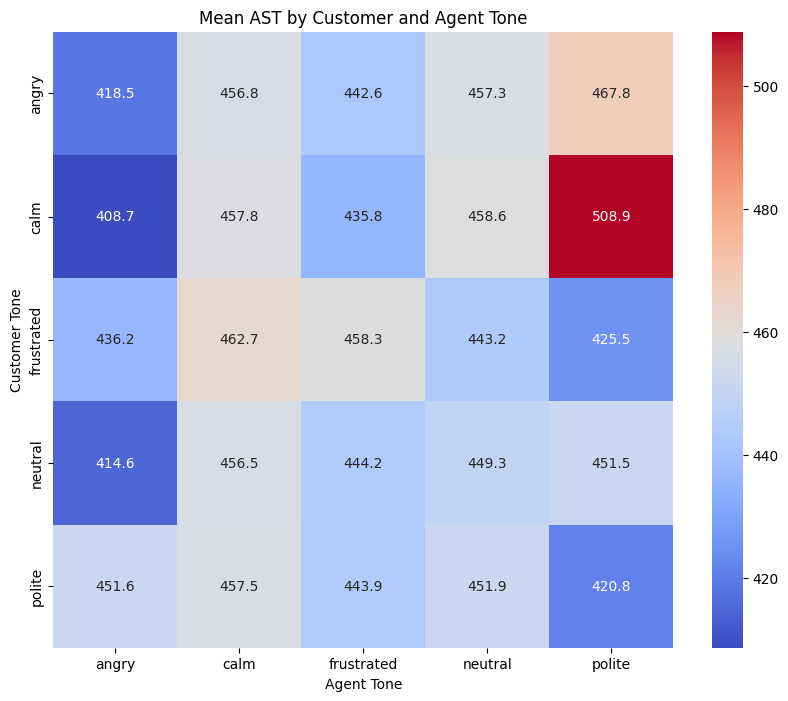

In [17]:
# Create a pivot table for mean AST
heatmap_data_ast = sentiment_stats.pivot_table(index='customer_tone', columns='agent_tone', values='mean_AST')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_ast, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Mean AST by Customer and Agent Tone')
plt.ylabel('Customer Tone')
plt.xlabel('Agent Tone')
plt.show()


### Analysing agent_id as a factor

In [18]:
# Calculate Mean AHT and AST by Agent
agent_performance = data.groupby('agent_id').agg(
    mean_AHT=('AHT', 'mean'),
    mean_AST=('AST', 'mean'),
    total_calls=('call_id', 'count')
).reset_index()

# Display the top few rows for an overview
print(agent_performance.sort_values(by='mean_AHT', ascending=False).head())

     agent_id  mean_AHT  mean_AST  total_calls
0      102574    3600.0     480.0            2
160    506130    2880.0     420.0            1
60     255256    2620.0     280.0            3
16     140146    2620.0     360.0            3
187    558705    1980.0     420.0            2


In [19]:
# Identify top performers (lowest AHT)
top_performers = agent_performance.nsmallest(5, 'mean_AHT')

# Identify bottom performers (highest AHT)
bottom_performers = agent_performance.nlargest(5, 'mean_AHT')

print("Top Performers (Lowest AHT):")
print(top_performers)

print("\nBottom Performers (Highest AHT):")
print(bottom_performers)


Top Performers (Lowest AHT):
     agent_id    mean_AHT    mean_AST  total_calls
184    547592  180.000000  600.000000            1
210    616988  285.000000  255.000000            4
23     161354  360.000000  420.000000            2
48     229129  373.333333  386.666667            9
238    676262  390.000000  450.000000            8

Bottom Performers (Highest AHT):
     agent_id  mean_AHT  mean_AST  total_calls
0      102574    3600.0     480.0            2
160    506130    2880.0     420.0            1
16     140146    2620.0     360.0            3
60     255256    2620.0     280.0            3
187    558705    1980.0     420.0            2


In [20]:
# Merge with original data to analyze call reasons and customer tones
top_agents_data = data[data['agent_id'].isin(top_performers['agent_id'])]
bottom_agents_data = data[data['agent_id'].isin(bottom_performers['agent_id'])]

# Group by primary_call_reason and agent_id for top performers
top_agent_reasons = top_agents_data.groupby(['primary_call_reason', 'agent_id']).agg(
    mean_AHT=('AHT', 'mean'),
    mean_AST=('AST', 'mean'),
    total_calls=('call_id', 'count')
).reset_index()

# Group by primary_call_reason and agent_id for bottom performers
bottom_agent_reasons = bottom_agents_data.groupby(['primary_call_reason', 'agent_id']).agg(
    mean_AHT=('AHT', 'mean'),
    mean_AST=('AST', 'mean'),
    total_calls=('call_id', 'count')
).reset_index()

# Display the results for top and bottom performer reasons
print("Top Performer Call Reasons:")
print(top_agent_reasons.head())

print("\nBottom Performer Call Reasons:")
print(bottom_agent_reasons.head())


Top Performer Call Reasons:
  primary_call_reason  agent_id  mean_AHT  mean_AST  total_calls
0             Baggage    161354     480.0     480.0            1
1            Check In    229129     120.0     480.0            1
2            Check In    616988     300.0     240.0            1
3            Checkout    676262     660.0     840.0            1
4      Communications    229129     120.0     300.0            2

Bottom Performer Call Reasons:
  primary_call_reason  agent_id  mean_AHT  mean_AST  total_calls
0             Booking    255256    5400.0     180.0            1
1              IRROPS    102574     300.0     420.0            1
2              IRROPS    140146     300.0     300.0            1
3              IRROPS    558705    1920.0     300.0            1
4       Mileage  Plus    140146    1320.0     300.0            1


In [21]:
mean_AHT = data['AHT'].mean()
mean_AST = data['AST'].mean()

In [22]:
data['handle_time'] = (data['call_end_datetime'] - data['call_start_datetime']).dt.total_seconds()
data['waiting_time'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds()

mean_AHT = data.groupby(['customer_tone', 'agent_tone'])['handle_time'].mean().reset_index()
mean_AST = data.groupby(['customer_tone', 'agent_tone'])['waiting_time'].mean().reset_index()

# Merge mean_AHT and mean_AST into a single DataFrame
sentiment_analysis = pd.merge(mean_AHT, mean_AST, on=['customer_tone', 'agent_tone'])
sentiment_analysis.columns = ['customer_tone', 'agent_tone', 'mean_AHT', 'mean_AST']


In [23]:
sentiment_analysis['total_calls'] = data.groupby(['customer_tone', 'agent_tone'])['call_id'].count().values
sentiment_analysis

,customer_tone,agent_tone,mean_AHT,mean_AST,total_calls
0,angry,angry,941.298701,443.376623,77
1,angry,calm,1060.093458,443.661113,4922
2,angry,frustrated,1054.426230,423.770492,732
3,angry,neutral,1183.966117,433.325598,8618
4,angry,polite,796.666667,456.666667,18
5,calm,angry,784.411765,431.470588,68
6,calm,calm,1076.518235,441.603869,4963
7,calm,frustrated,1030.275762,422.264151,689
8,calm,neutral,1186.753065,436.749562,8565
9,calm,polite,670.588235,532.941176,17


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id                 71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
 7   customer_name            71810 non-null  object        
 8   elite_level_code         71810 non-null  float64       
 9   primary_call_reason      66653 non-null  object        
 10  agent_tone               71593 non-null  object        
 11  customer_tone            71810 non-null  object        
 12  average_sentiment        71701 n

In [26]:
# Print the distribution of average_sentiment
print(data['average_sentiment'].describe())

count    71701.000000
mean        -0.033519
std          0.143715
min         -1.380000
25%         -0.110000
50%         -0.020000
75%          0.050000
max          2.670000
Name: average_sentiment, dtype: float64


### Analysis based on average_sentiment

In [27]:
# Categorize average_sentiment into 'Negative', 'Neutral', 'Positive'
bins_sentiment = [-float('inf'), -0.1, 0.05, float('inf')]  # Adjusted based on data distribution
labels_sentiment = ['Negative', 'Neutral', 'Positive']
data['sentiment_category'] = pd.cut(data['average_sentiment'], bins=bins_sentiment, labels=labels_sentiment)

In [28]:
data['call_duration'] = (pd.to_datetime(data['call_end_datetime']) - pd.to_datetime(data['call_start_datetime'])).dt.total_seconds()
data['wait_time'] = (pd.to_datetime(data['agent_assigned_datetime']) - pd.to_datetime(data['call_start_datetime'])).dt.total_seconds()

In [29]:
sentiment_impact = data.groupby('sentiment_category').agg(
    mean_AHT=('call_duration', 'mean'),
    mean_AST=('wait_time', 'mean'),
    total_calls=('call_id', 'count')
).reset_index()

In [30]:
sentiment_impact

,sentiment_category,mean_AHT,mean_AST,total_calls
0,Negative,1164.152355,429.832193,20321
1,Neutral,1192.114589,436.832254,35047
2,Positive,973.720688,446.464214,16333


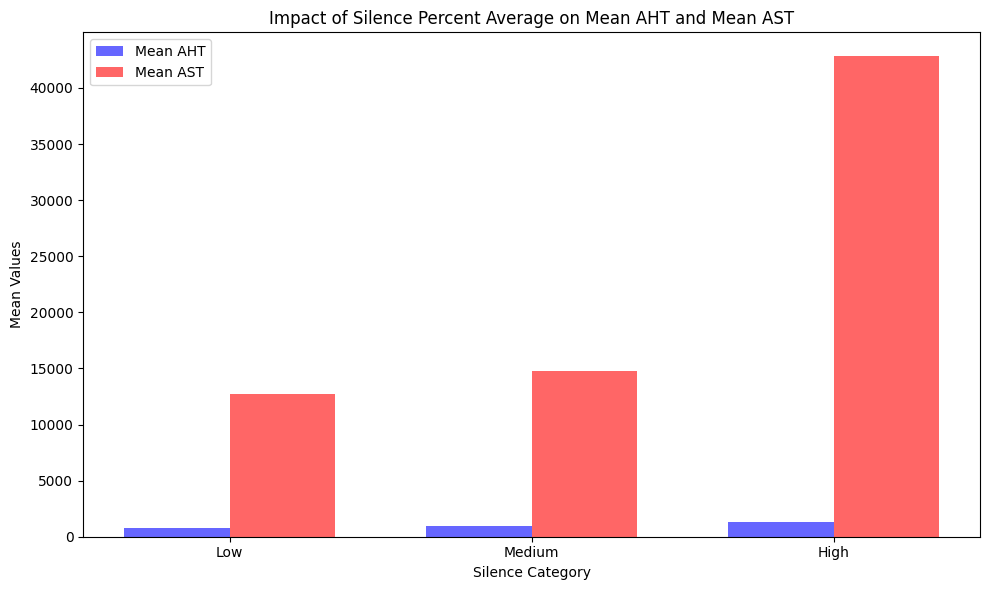

In [36]:
bins_silence = [0, 0.1, 0.2, float('inf')]  # Define bins for silence percent average
labels_silence = ['Low', 'Medium', 'High']  # Define corresponding labels
data['silence_category'] = pd.cut(data['silence_percent_average'], bins=bins_silence, labels=labels_silence)

# Step 2: Create a pivot table to analyze mean AHT and mean AST by silence categories
silence_pivot_table = data.pivot_table(
    index='silence_category',
    values=['call_duration', 'wait_time', 'call_id'],
    aggfunc={
        'call_duration': 'mean',  # Mean AHT
        'wait_time': 'mean',       # Mean AST
        'call_id': 'count'         # Total calls
    }
).reset_index()

# Rename the columns for clarity
silence_pivot_table.columns = ['silence_category', 'mean_AHT', 'mean_AST', 'total_calls']

# Step 3: Plotting the results
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35
index = range(len(silence_pivot_table))

# Plotting mean AHT
ax.bar(index, silence_pivot_table['mean_AHT'], bar_width, label='Mean AHT', color='b', alpha=0.6)

# Plotting mean AST next to AHT bars
ax.bar([i + bar_width for i in index], silence_pivot_table['mean_AST'], bar_width, label='Mean AST', color='r', alpha=0.6)

# Adding labels and title
ax.set_xlabel('Silence Category')
ax.set_ylabel('Mean Values')
ax.set_title('Impact of Silence Percent Average on Mean AHT and Mean AST')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(silence_pivot_table['silence_category'])
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()
